# Capstone Sprint 3
**Author**: Eileen Cai  
**Contact**: eileen.ch.cai@gmail.com  
**Date**: Mar 31, 2024

## Introduction
My project focuses on leveraging machine learning techniques for content moderation on social media platforms, specifically targeting the automatic detection of harmful texts. Through advanced natural language processing (NLP) methods, we aim to encode textual data into numerical matrices and employ machine learning models for sentiment analysis. By rigorously testing multiple models, we aim to identify the most effective approach in terms of accuracy, precision, and recall.

My analysis centers on a meticulously curated dataset comprising annotated tweets, carefully selected to facilitate the detection of hate speech and offensive language. This dataset predominantly consists of English tweets and serves as a robust foundation for training machine learning models or algorithms in hate speech detection. The target variable of interest `class` categorizes tweets into three classes: hate speech (0), offensive language (1), and neutral content (2).

## Table of contents
[1. Data Dictionary](#dict)  

[2. Load Data](#load)

[3. Exploratory Data Analysis](#eda)
- [Shape and Data Structure](#data)
- [Null Values and Duplicated Rows](#null)
- [Distribution of Columns](#feature)
- [Distribution of Target Column](#target)

[4. Preprocessing](#pre)
- [Train / Test Split](#split)
- [Re-sampling](#resample)
- [Vectorization](#vect)

[5. Modeling](#model)
- [Logistic Regression](#logreg)
- [Random Forest](#rf)
- [XGBoost](#xg)

[6. Conclusion](#con)

## Data Dictionary <a class="anchor" id="dict"></a>  
<table align="left">
  <tr>
    <th style="text-align:left;">Column</th>
    <th style="text-align:left;">Data Type</th>
    <th style="text-align:left;">Description</th>
  </tr>
  <tr>
    <td style="text-align:left;">count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The total number of annotations for each tweet.</td>
  </tr>
  <tr>
    <td style="text-align:left;">hate_speech_count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The number of annotations classifying a tweet as hate speech.</td>
  </tr>
  <tr>
    <td style="text-align:left;">offensive_language_count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The number of annotations classifying a tweet as offensive language.</td>
  </tr>
  <tr>
    <td style="text-align:left;">neither_count</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">The number of annotations classifying a tweet as neither hate speech nor offensive language.</td>
  </tr>
  <tr>
    <td style="text-align:left;">class</td>
    <td style="text-align:left;">int</td>
    <td style="text-align:left;">Category to which a tweet belongs. <strong>(Target)</strong></td>
  </tr>
  <tr>
    <td style="text-align:left;">tweet</td>
    <td style="text-align:left;">str</td>
    <td style="text-align:left;">The atual text of the tweet.</td>
  </tr>
</table>

## Load Data <a class="anchor" id="load"></a>  
Before loading in our data, we are going to import some of our essential packages that will be used throughout the entire notebook.

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Now we can use Pandas to read our csv file into a data frame and take a quick look at a portion of the data to make sure that it was loaded in correctly.

In [2]:
# Read in csv
df = pd.read_csv('train.csv')
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Looking at our data frame, we can immediately see that columns `hate_speech_count`, `offensive_language_count` and `neither_count` are the 3 classes from our target column `class`. Therefore, including them would create multicollinearity. We should only be using column `tweet` as our feature to predict our target `class`.

Later on, we will have to do some text processing for the `tweet` column so that we can use it in our modeling.

## Exploratory Data Analysis <a class="anchor" id="eda"></a>
Now that we have loaded in our data, we can perform some quick Exploratory Data Analysis. We have been told that the data is a meticulously curated collection of annotated tweets with the specific purpose of detecting hate speech and offensive language, but it is best practice to verify this so that we do not run into any surprises when preprocessing or modeling.

### Shape and Data Structure <a class="anchor" id="data"></a>
Let's take a look at the shape and all of the columns in our data:

In [3]:
# Take a look at the shape of dataset
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the dataset.')

There are 24783 rows and 6 columns in the dataset.


In [4]:
# Checking the type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


### Null Values and Duplicated Rows <a class="anchor" id="null"></a>  
Next, let's make sure that our data has no NULL values or duplicated rows:

In [5]:
# Check null values
print(f'There are {df.isna().sum().sum()} NULL values in the dataset.')

There are 0 NULL values in the dataset.


In [6]:
# Check duplicated rows
print(f'There are {df.duplicated().sum()} duplicated rows in the dataset.')

There are 0 duplicated rows in the dataset.


We have no duplicated rows and our data is clean of any missing values.

### Distribution of Columns <a class="anchor" id="feature"></a>  
Since almost all of our columns are numerical, let's take a look at their distributions. Let's create a new data frame, dropping our target column `class` (we will have a separate section for it later on) and feature column `tweet` as it doesn't make sense to plot the distribution of non-numerical values.

In [8]:
dist_df = df.drop(columns=['class', 'tweet'])

Let's plot out histograms of each column's distribution:

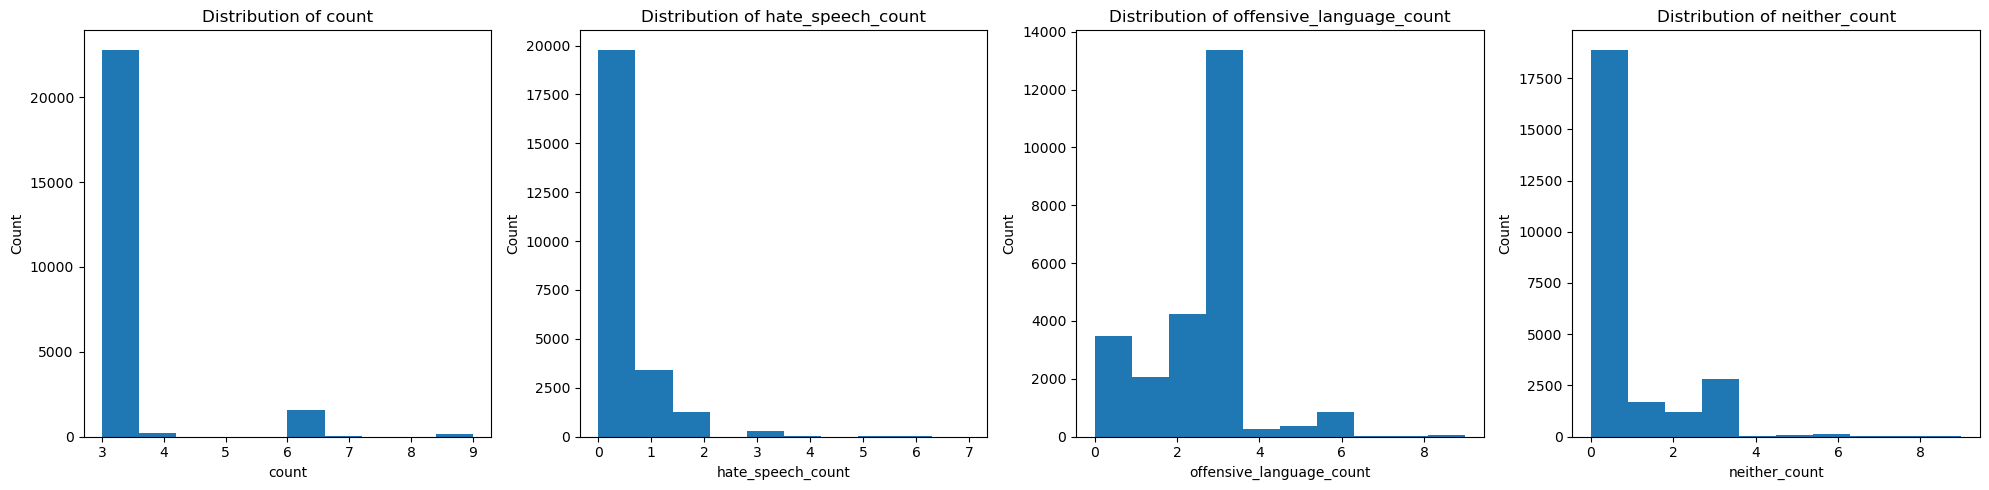

In [9]:
plt.figure(figsize=(20,5))
for i, col in enumerate(dist_df.columns):
    plt.subplot(1,4, i+1)
    plt.hist(dist_df[col])
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

To fully understand the distributions of the columns, we can pair these visuals with a statistical summary:

In [10]:
# Statistical summary
dist_df.describe().T

,count,mean,std,min,25%,50%,75%,max
count,24783.0,3.243473,0.883060,3.0,3.0,3.0,3.0,9.0
hate_speech_count,24783.0,0.280515,0.631851,0.0,0.0,0.0,0.0,7.0
offensive_language_count,24783.0,2.413711,1.399459,0.0,2.0,3.0,3.0,9.0
neither_count,24783.0,0.549247,1.113299,0.0,0.0,0.0,0.0,9.0


**Observations:** We can see that the total number of annotations given for each tweet on average is 3, which makes sense since we have 3 classes. The number of annotations classifying a tweet as offensive language has the greatest count, as we'll also see in the target distribution later on.

### Distribution of Target Column <a class="anchor" id="target"></a>  
Let's take a look at our target column `class` and see how our data is split so that we can better understand how our model is going to perform.

In [11]:
# Check class proportions
df['class'].value_counts(normalize=True).sort_index()

class
0    0.057701
1    0.774321
2    0.167978
Name: proportion, dtype: float64

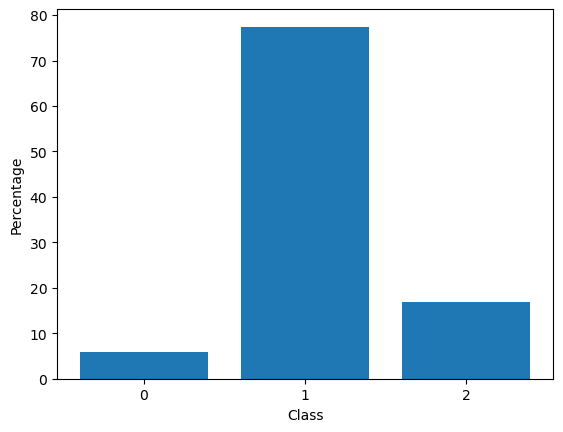

Class imbalance: [0.06 0.77 0.17]


In [12]:
# Bar chart of class
values, counts = np.unique(df['class'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(['0', '1', '2'], normalized_counts*100) # plot normalized counts
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

print(f'Class imbalance: {np.round(normalized_counts, 2)}')

In this data set, the class ranges from 0 to 2. We can look at a few sample tweets and their associated class.

In [13]:
print(df[['tweet', 'class']].sample(4).values)

[['That nigga talkin like a hoe Tell that bitch nigga speak up' 1]
 ['@MarieJoseGMH @DWB666 @seahopke @zenterrorist86 tegenwoordig weet je ook al niet wat voor vlees je eet,voor je t weet is t zebra of een aap'
  2]
 ['Before I let a pussy cut my hair I just will let it grow' 1]
 ['Fuuuuuck you you stupid fucking cunt' 1]]


**Observations:** The tweets have been annotated into three classes. 
- class 0 - hate speech
- class 1 - offensive language
- class 2 - neither 

Our target column is very imbalanced, with class 1 taking up 77% of the data, class 2 taking up 17% and class 0 only 6%. To potentially improve our model, we will resample the observations that belong to the under-represented and over-represented classes so that our training data consists of equal proportions of each class in the preprocessing stage.

## Preprocessing <a class="anchor" id="pre"></a>  
Now that we have explored our data more in depth, we can move onto preprocessing our text features, `tweet` for modeling.

### Train / Test Split <a class="anchor" id="split"></a>  
Since `tweet` is the only feature we have to predict `class`, we will set `tweet` as our X and `class` as our y.

In [14]:
# Define X (feature) and y (target)
X = df['tweet']
y = df['class']

After assigning our X and y, we can perform a train/test split with SKLearn. We will be using a test size of 20% as well as stratifying due to the imbalance of our data.

We split our data in train and test sets so that we can test our model on unseen data. Testing on unseen data is the last step in the modeling process to validate that our model can still perform well when it comes across data that it doesn't know.

In [15]:
# import train_test_split
from sklearn.model_selection import train_test_split

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [16]:
# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 19826 data points.
The TEST set has 4957 data points.


### Re-sampling <a class="anchor" id="resample"></a>  
After splitting our data into train and test sets, we can upsample the minority class 0 and downsample the majority class 1 to match the size of class 2, so that our training data consists of equal proportions of each class.

In [17]:
# Import package 
from sklearn.utils import resample

# Upsample class 0
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_upsampled, y_upsampled = resample(X_train[y_train == 0], 
                                    y_train[y_train == 0], 
                                    replace=True, 
                                    n_samples=X_train[y_train == 2].shape[0], 
                                    random_state=123)

print('Number of class 0 examples after:', X_upsampled.shape[0])

Number of class 0 examples before: 1144
Number of class 0 examples after: 3330


In [18]:
# Downsample class 1 
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 1], 
                                        y_train[y_train == 1], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 2].shape[0], 
                                        random_state=123)

print('Number of class 1 examples after:', X_downsampled.shape[0])

# Combine upsample and downsample with original train data
X_train = np.hstack((X_upsampled, X_train[y_train == 2], X_downsampled))
y_train = np.hstack((y_upsampled, y_train[y_train == 2], y_downsampled))

Number of class 1 examples before: 15352
Number of class 1 examples after: 3330


In [19]:
# Check the sizes of resampled train and test sets
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 9990 data points.
The TEST set has 4957 data points.


The new proportions of class 0 and class 1 match that of class 2 training data sets and the combined training sets look correct (3330 * 3 = 9990). We can move on to vectorizing our `tweet` column.

### Vectorization <a class="anchor" id="vect"></a>  
We will be comparing Count Vectorizer using bag-of-words and Word Embedding using Word2Vec from pre-trained vectors to see which text representation yields better model performance. 

First, let's create a custom tokenizer to clean the tweets before putting them into a vectorizer. This function will go through a 3 step process:
1. Remove all punctuation and convert text to lower case
2. Split the string and remove stop words (common English words found in almost every sentence that will not be useful in predictions)
3. Lemmatize each word in the string (normalize words so that different inflected forms of the same word are treated as the same word)

In [20]:
# Import string (punctuations), stop words and lemmatizer 
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tokenizer function
lemmatizer = WordNetLemmatizer()
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    '''
    Takes a sentence:
    - Removes the punctuation & converts text to lower case
    - Separates and removes stop words
    - Lemmatizes the remaining tokens
    
    Returns list of lemmatized tokens
    '''
    # Remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark, '').lower()
    
    # Split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
    
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word != ''):
            # Lemmatize words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)
            
    return listoflemmatized_words

Now that we have the cleaning function layed out, we can move onto creating a function for word embeddings. We will use [LexVec](https://github.com/alexandres/lexvec) and Wikipedia as pre-trained vectors and load up a gensim model with these Wikipedia word vectors:

In [21]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format(
    'lexvec-wikipedia-word-vectors', binary=False
)

All the word vectors in the model are stored in a single numpy array in the `vectors` attribute of the model object. Let's check the shape of our model:

In [22]:
model.vectors.shape

(368999, 300)

From this, we see that our model stores embeddings to almost 370,000 unique words and each word vector has 300 coordinates. Let's build a function that can embed any sentence by skipping words not in the model:

In [23]:
def sentence2vec(text):
    """
    Embed a sentence by averaging the word vectors of the tokenized text. Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = my_tokenizer(text)
    
    word_embeddings = [np.zeros(300)]
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
    
    return sentence_embedding

Next, we're going to create a custom transformer for the sentence2vec function above so that we can use it in our pipeline later on. 

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class Sentence2vecTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result = []
        for sentence in X:
            vector = sentence2vec(sentence)
            result.append(vector)
        
        result = np.array(result)
        return result

## Modeling <a class="anchor" id="model"></a>  
We will be comparing three models, namely, logistic regression, random forest, and XGBoost, to see which model yields the best results. For model evaluation, we'll be using the weighted average of F1 and recall scores.

### Logistic Regression <a class="anchor" id="logreg"></a>  

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Estimator
logreg = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", LogisticRegression(max_iter=1000, random_state=123)),
    ]
)

# Parameters
params = {'classifier__C': [0.01, 0.1, 1, 10, 100],
          'vectorizer':[CountVectorizer(tokenizer=my_tokenizer, min_df=5, max_features=300),
                        Sentence2vecTransformer()]}

# Grid Search
grid_logreg = GridSearchCV(logreg, param_grid=params, cv=5, verbose=1)
grid_logreg.fit(X_train, y_train)

print("Best parameters: ", grid_logreg.best_params_)
print(f"The best logistic regression's accuracy on the TRAIN set: {round(grid_logreg.score(X_train, y_train), 3)}")
print(f"The best logistic regression's accuracy on the TEST set: {round(grid_logreg.score(X_test, y_test), 3)}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'classifier__C': 1, 'vectorizer': CountVectorizer(max_features=300, min_df=5,
                tokenizer=<function my_tokenizer at 0x1259637e0>)}
The best logistic regression's accuracy on the TRAIN set: 0.832
The best logistic regression's accuracy on the TEST set: 0.793


Next, let's look at the top 20 words that are most predictive of each class.

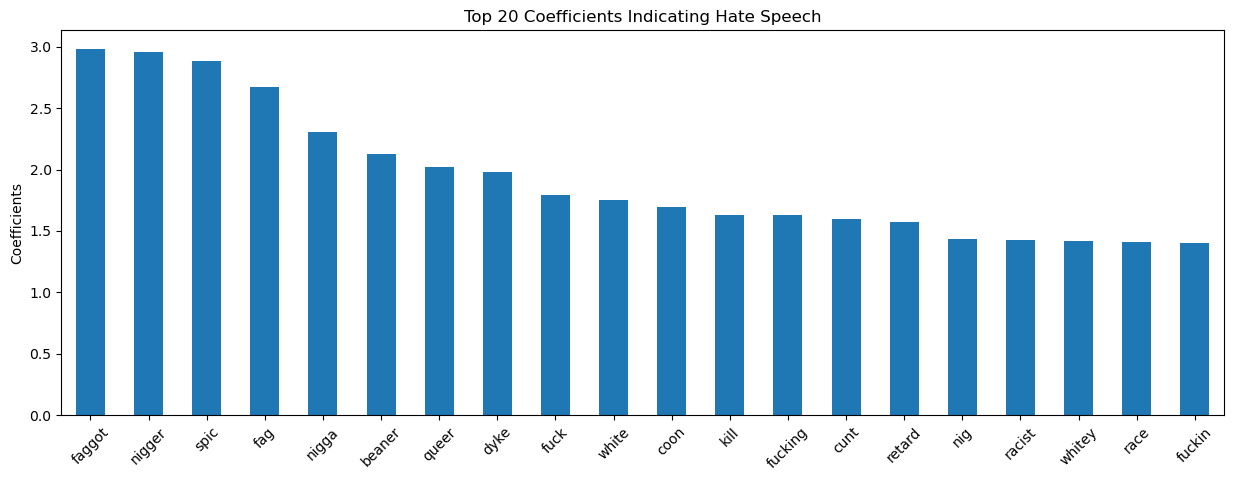

In [26]:
word_counts = pd.DataFrame(
    {"coefficients": grid_logreg.best_estimator_.named_steps['classifier'].coef_[0]},
    index=grid_logreg.best_estimator_.named_steps['vectorizer'].get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 Coefficients Indicating Hate Speech")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

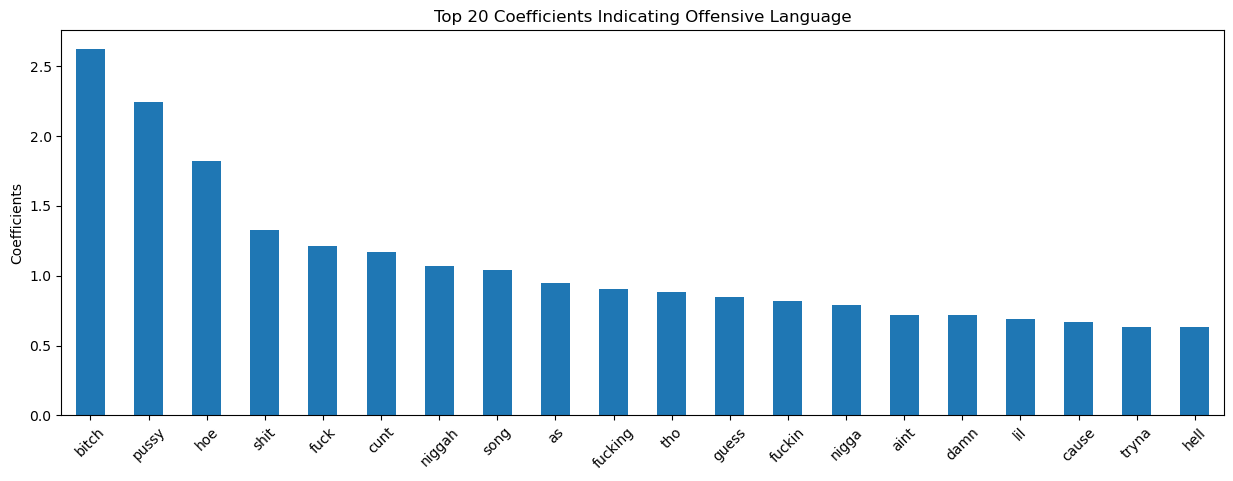

In [27]:
word_counts = pd.DataFrame(
    {"coefficients": grid_logreg.best_estimator_.named_steps['classifier'].coef_[1]},
    index=grid_logreg.best_estimator_.named_steps['vectorizer'].get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 Coefficients Indicating Offensive Language")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

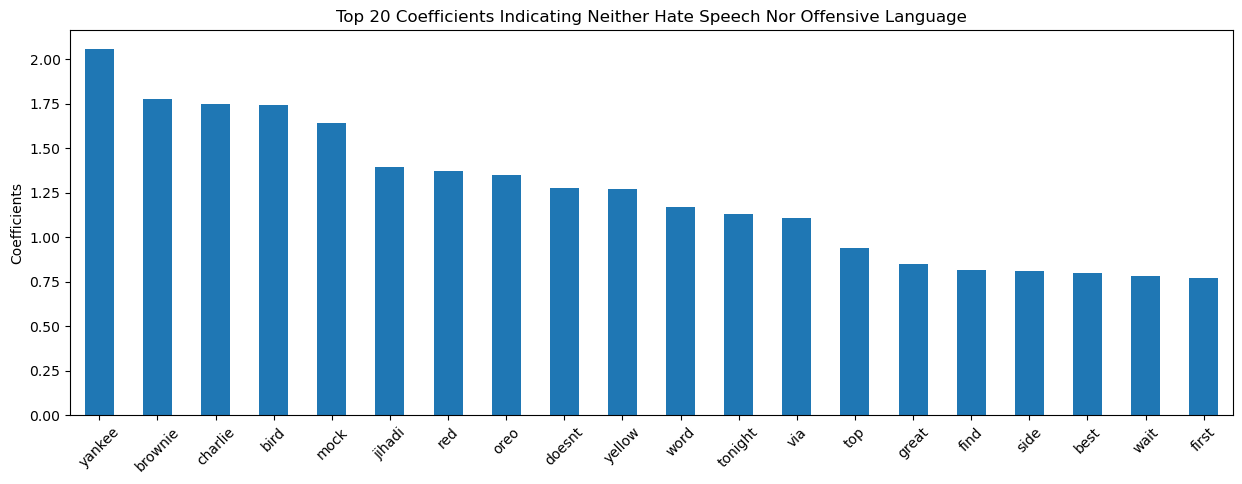

In [28]:
word_counts = pd.DataFrame(
    {"coefficients": grid_logreg.best_estimator_.named_steps['classifier'].coef_[2]},
    index=grid_logreg.best_estimator_.named_steps['vectorizer'].get_feature_names_out()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 Coefficients Indicating Neither Hate Speech Nor Offensive Language")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

**Observations:** 
- In the hate speech, we see words that we expect such as faggot, nigger, queer, white, wetback, dyke, etc.
- In the offensive language, we also see words that we expect such as bitch, pussi, hoe, shit, fuck, cunt, etc.
- In the neither hate speech nor offensive language, we see neutral words, such as yankee, brownie, charlie, bird, oreo, etc.
- There are also some words that we see in common such as fuck, niggah, ass, that appear in both hate speech and offensive language. This could be due to variations in classification between annotators since annotations are subjective opinions provided by individual annotators.

Let's also take a look at our classification report and confusion matrix:

              precision    recall  f1-score   support

           0       0.23      0.65      0.34       286
           1       0.97      0.77      0.86      3838
           2       0.72      0.93      0.81       833

    accuracy                           0.79      4957
   macro avg       0.64      0.78      0.67      4957
weighted avg       0.88      0.79      0.82      4957



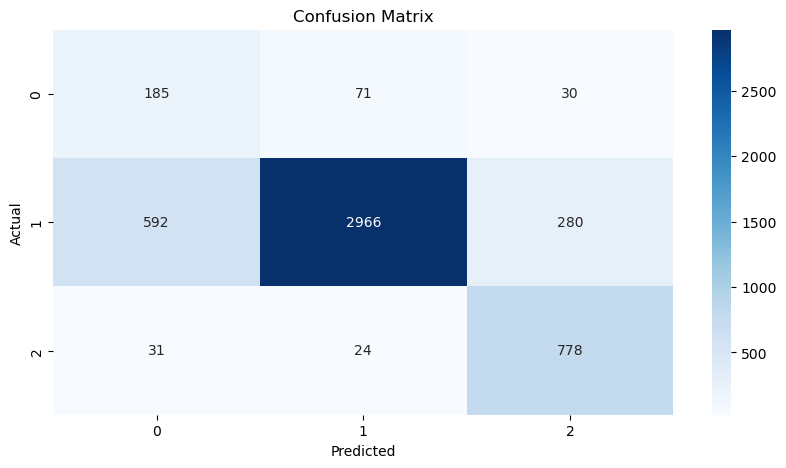

In [29]:
# Import classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix heatmap
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Here is our model summary:

|Model|Vectorizer|Parameters|Train Accuracy (%)|Test Accuracy (%)|F1-Score (weighted avg)|Recall (weighted avg)
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Logistic Regression|CountVectorizer|C=1|83.2|79.3|82|79|

### Random Forest <a class="anchor" id="rf"></a> 

In [36]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Estimator
rf = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", RandomForestClassifier(n_jobs=-1, random_state=123)),
    ]
)

# Parameters
params = {'classifier__n_estimators': np.arange(100, 1000, 100),
          'classifier__max_depth': [None, 10, 20, 30],
          'vectorizer':[CountVectorizer(tokenizer=my_tokenizer, min_df=5, max_features=300),
                        Sentence2vecTransformer()]}

# Grid Search
grid_rf = GridSearchCV(rf, param_grid=params, cv=5, verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best parameters: ", grid_rf.best_params_)
print(f"The best Random Forest's accuracy on the TRAIN set: {round(grid_rf.score(X_train, y_train), 3)}")
print(f"The best Random Forest's accuracy on the TEST set: {round(grid_rf.score(X_test, y_test), 3)}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

Best parameters:  {'classifier__max_depth': 20, 'classifier__n_estimators': 900, 'vectorizer': Sentence2vecTransformer()}
The best Random Forest's accuracy on the TRAIN set: 0.998
The best Random Forest's accuracy on the TEST set: 0.821


Let's also take a look at our classification report and confusion matrix:

              precision    recall  f1-score   support

           0       0.46      0.30      0.36       286
           1       0.95      0.84      0.89      3838
           2       0.55      0.93      0.69       833

    accuracy                           0.82      4957
   macro avg       0.65      0.69      0.65      4957
weighted avg       0.86      0.82      0.83      4957



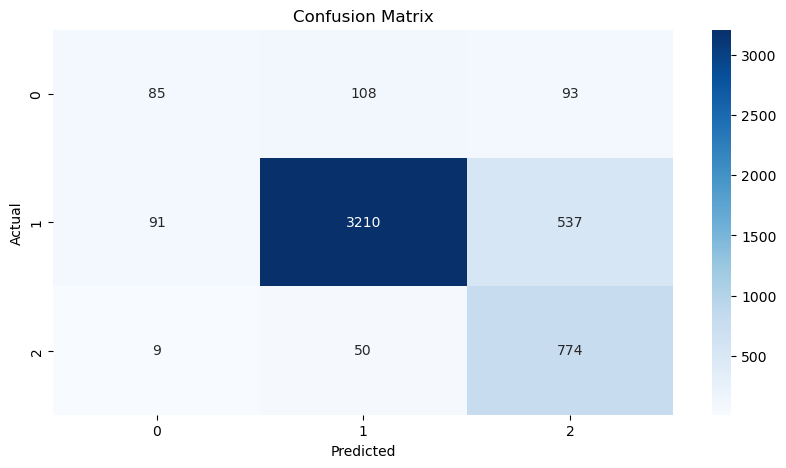

In [37]:
# Make predictions on the test data
y_pred = grid_rf.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix heatmap
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Here is our model summary:

|Model|Vectorizer|Parameters|Train Accuracy (%)|Test Accuracy (%)|F1-Score (weighted avg)|Recall (weighted avg)
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Logistic Regression|CountVectorizer|C=1|83.2|79.3|82|79|
|Random Forest|Sentence2vecTransformer|max_depth=20, n_estimators=900|99.8|82.1|83|82|

### XGBoost <a class="anchor" id="xg"></a>  

In [34]:
# Import XGBoost classifier
from xgboost import XGBClassifier

# Estimator
xgb = Pipeline(
    [
        ("vectorizer", CountVectorizer()),
        ("classifier", XGBClassifier(n_jobs=-1, random_state=123)),
    ]
)

# Parameters
params = {'classifier__n_estimators': np.arange(1, 1000, 10),
          'classifier__max_depth': np.arange(1,5),
          'vectorizer':[CountVectorizer(tokenizer=my_tokenizer, min_df=5, max_features=300),
                        Sentence2vecTransformer()]}

# Grid Search
grid_xgb = GridSearchCV(xgb, param_grid=params, cv=5, verbose=1, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best parameters: ", grid_xgb.best_params_)
print(f"The best XGBoost's accuracy on the TRAIN set: {round(grid_xgb.score(X_train, y_train), 3)}")
print(f"The best XGBoost's accuracy on the TEST set: {round(grid_xgb.score(X_test, y_test), 3)}")

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/eileencai/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not Non

Best parameters:  {'classifier__max_depth': 4, 'classifier__n_estimators': 481, 'vectorizer': Sentence2vecTransformer()}
The best XGBoost's accuracy on the TRAIN set: 0.998
The best XGBoost's accuracy on the TEST set: 0.836


Let's also take a look at our classification report and confusion matrix:

              precision    recall  f1-score   support

           0       0.35      0.46      0.40       286
           1       0.96      0.84      0.90      3838
           2       0.64      0.94      0.76       833

    accuracy                           0.84      4957
   macro avg       0.65      0.75      0.69      4957
weighted avg       0.87      0.84      0.85      4957



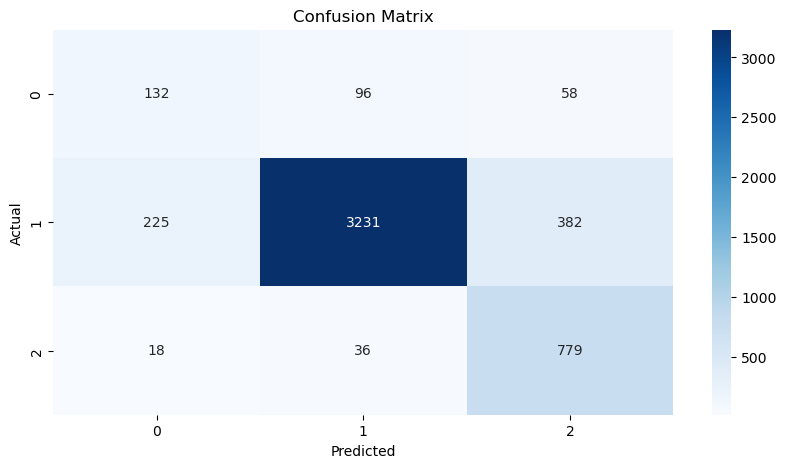

In [35]:
# Make predictions on the test data
y_pred = grid_xgb.best_estimator_.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix heatmap
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Here is our model summary:

|Model|Vectorizer|Parameters|Train Accuracy (%)|Test Accuracy (%)|F1-Score (weighted avg)|Recall (weighted avg)
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|Logistic Regression|CountVectorizer|C=1|83.2|79.3|82|79|
|Random Forest|Sentence2vecTransformer|max_depth=20, n_estimators=900|99.8|82.1|83|82|
|XGBoost|Sentence2vecTransformer|max_depth=4, n_estimators=481|99.8|83.6|85|84|

## Conclusion <a class="anchor" id="con"></a>

We see that XGBoost is the best performing model in terms of having the highest accuracy, F1 and recall scores. The model performs well in predicting instances belonging to class 1 - offensive language (high precision, recall, and F1-score) and class 2 - neither (high recall and relatively high F1-score), but it performs less well for class 0 - hate speech (low precision, recall, and F1-score). The weighted average precision, recall, and F1-score (0.87, 0.84, and 0.85, respectively) suggest that the model performs reasonably well overall, with some room for improvement, especially for class 0. This looks reasonable because our classes are extremely imbalanced with class 1 having the highest support (3838 instances), followed by class 2 (833 instances), and class 0 (286 instances). The model's overall accuracy is 0.84, indicating that the model correctly predicted 84% of all instances across all classes. For next steps, we'd want to explore alternative vectorization techniques, such as, finding a pre-trained word vector library that is more suitable for informal languages like tweet. We could also test out different tokenizations and hyperparameter tuning for better prediction results. 